# PS5, XBOX SERIES X, Nintendo Switch Sentiment Analysis

# Getting data

In [1]:
import snscrape.modules.reddit as sn
import tqdm.notebook as tqdm
import numpy as np
import pandas as pd

In [2]:
ps5 = sn.RedditSearchScraper("Playstation 5")
xbox = sn.RedditSearchScraper("Xbox series X")
switch =  sn.RedditSearchScraper("Nintendo Switch")

In [3]:
ps5comments = []
for i,comment in enumerate(ps5.get_items()):
    try:
        ps5comments.append(comment.body)
    except:
        ps5comments.append(np.nan)
    if i > 8000:
        break
xboxcomments = []
for i,comment in enumerate(ps5.get_items()):
    try:
        xboxcomments.append(comment.body)
    except:
        xboxcomments.append(np.nan)
    if i > 8000:
        break
switchcomments = []
for i,comment in enumerate(switch.get_items()):
    try:
        switchcomments.append(comment.body)
    except:
        switchcomments.append(np.nan)
    if i > 8000:
        break
    

In [4]:
df = pd.DataFrame([switchcomments,ps5comments,xboxcomments]).T
df.rename(columns={0:"switch",1:"ps5",2:"xbox"},inplace=True)

# Cleaning data

#### Removing ads

In [5]:
df = df.applymap(lambda x: x if isinstance(x, str) and x.find('https://')==-1 else np.nan)


In [6]:
def missing (df1):
    missing_number = df1.isnull().sum().sort_values(ascending=False)
    missing_percent = ((df1.isnull().sum()/df1.isnull().count())*100).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

In [14]:
missing(df)

,Missing_Number,Missing_Percent
ps5,5291,66.120970
xbox,5291,66.120970
switch,3927,49.075231


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8002 entries, 0 to 8001
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   switch  4075 non-null   object
 1   ps5     2711 non-null   object
 2   xbox    2711 non-null   object
dtypes: object(3)
memory usage: 187.7+ KB


#### Creating three dataframes to label independently

In [12]:
switch = df['switch'].to_frame()
xbox = df['xbox'].to_frame()
ps5 = df['ps5'].to_frame()
ps5 = ps5.dropna()
xbox=xbox.dropna()
switch = switch.dropna()

In [21]:
switch = switch.iloc[0:2711,:]

# Labeling Sentiment

In [7]:
switch['switch'] = switch['switch'].str[:512]
ps5['ps5'] = ps5['ps5'].str[:512]
xbox['xbox'] = xbox['xbox'].str[:512]


In [19]:
switch = switch.iloc[:1000]

ps5 = ps5.iloc[:1000]

xbox = xbox.iloc[:1000]

In [2]:
import snscrape.modules.twitter as sn
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import datetime as datetime
from transformers import AutoTokenizer,AutoModelForSequenceClassification
import torch

In [7]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [8]:
tokens = []
for i in tqdm(range(len(xbox.xbox))):
    tokens.append(tokenizer.encode(list(xbox.xbox)[i],return_tensors='pt'))
results = []
    # Iterate over the tensors
for i,n in tqdm(enumerate(tokens)):
    # Get the result from the model
    result = model(tokens[i])
    results.append(result.logits)
ratings =[]
for i in tqdm(range(len(results))):
    ratings.append(torch.argmax(results[i]))
xbox['rating'] = ratings

  0%|          | 0/1000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [3]:
switch.rating = switch.rating.str.replace("tensor",'').str.replace(")","").str.replace('(',"").astype("int")
xbox.rating = xbox.rating.str.replace("tensor",'').str.replace(")","").str.replace('(',"").astype("int")
ps5.rating = ps5.rating.str.replace("tensor",'').str.replace(")","").str.replace('(',"").astype("int")
ps5['console'] = 'PS5'
xbox['console'] = 'XboxS1'
switch['console'] = 'Switch'
switch.rename(columns={'switch':'comment'},inplace=True)
xbox.rename(columns={'xbox':'comment'},inplace=True)
ps5.rename(columns={'ps5':'comment'},inplace=True)
df = pd.concat((switch,ps5,xbox)).iloc[:,:3]

C:\Users\charl.DESKTOP-E4F6RTP\AppData\Local\Temp\ipykernel_26100\2753348029.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  switch.rating = switch.rating.str.replace("tensor",'').str.replace(")","").str.replace('(',"").astype("int")
C:\Users\charl.DESKTOP-E4F6RTP\AppData\Local\Temp\ipykernel_26100\2753348029.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  xbox.rating = xbox.rating.str.replace("tensor",'').str.replace(")","").str.replace('(',"").astype("int")
C:\Users\charl.DESKTOP-E4F6RTP\AppData\Local\Temp\ipykernel_26100\2753348029.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regul

# Visualization 

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
df.head()

,comment,rating,console
0,Counterpoint: the third parties who make games...,2,Switch
1,&gt;Nintendo Switch is all set to get a succes...,0,Switch
2,Hi! Thank you for your submission to /r/Ninten...,2,Switch
3,I don't know. With Pokemon having just release...,1,Switch
4,Nintendo is about to send a cease and desist o...,0,Switch


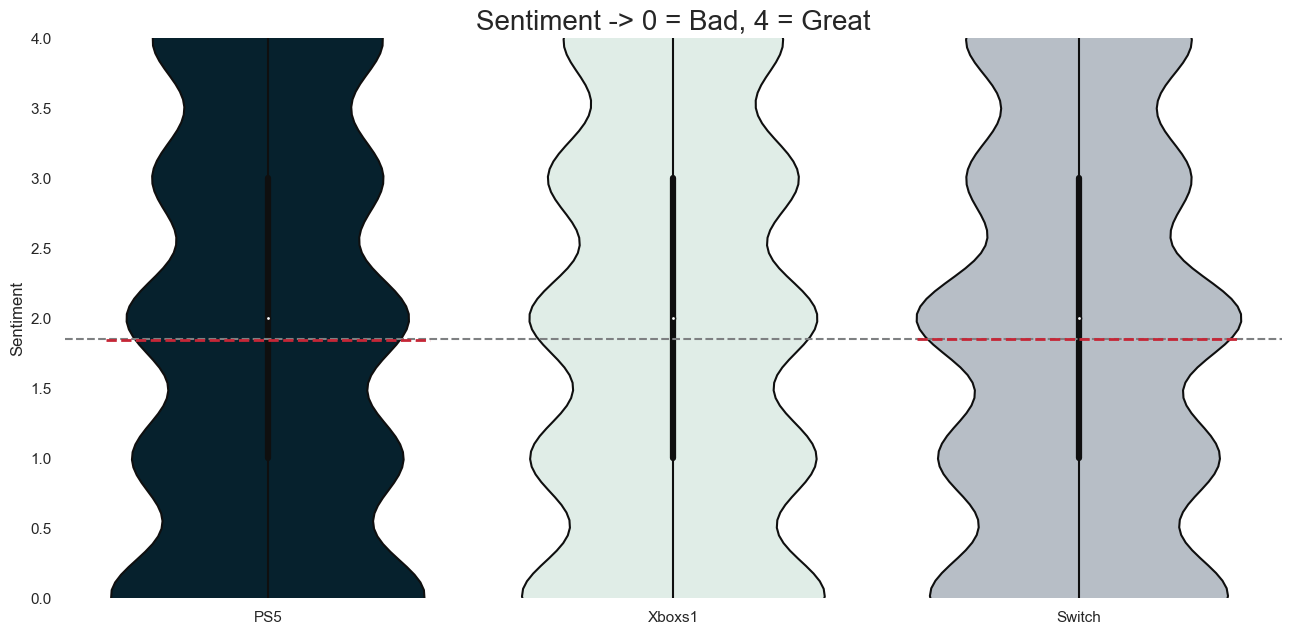

In [25]:
colors = ['#002333','#DEEFE7','#B4BEC9']
sns.set(rc={'figure.figsize':(15.7,7.27)})

sns.despine(bottom = True, left = True)
sns.set_style('white')
ax = sns.violinplot(data=df,x="console",y="rating",jitter=True,palette=colors,linewidth=None,size = 1.5,dodge=True,order = ['PS5','XboxS1','Switch'])
sns.boxplot(showmeans=True,
            meanline=True,
            medianprops={'visible': False},
            meanprops={'color': "#C52636", 'ls': 'dashed', 'lw': 2},
            whiskerprops={'visible': False},
            zorder=10,
            x="console",
            y="rating",
            data=df,
            showfliers=False,
            showbox=False,
            showcaps=False,order = ['PS5','Xboxs1','Switch'])
plt.axhline(df['rating'].mean(),color="#7E8082",linestyle="--",label='Mean Score')
plt.ylim(top=4,bottom=0)
plt.title("Sentiment -> 0 = Bad, 4 = Great",fontsize=20)
ax.set_ylabel('Sentiment')
ax.set_xlabel("")
sns.despine(bottom = True, left = True)
sns.set_style({'axes.facecolor':'white', 'grid.color': '.8', 'font.family':'century gothic'})
plt.show()

In [18]:
df.describe()

,rating
count,3000.000000
mean,1.846667
std,1.396593
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,4.000000


In [20]:
df.groupby('console').rating.describe()

,count,mean,std,min,25%,50%,75%,max
console,,,,,,,,
PS5,1000.0,1.842,1.416701,0.0,1.0,2.0,3.0,4.0
Switch,1000.0,1.850,1.381814,0.0,1.0,2.0,3.0,4.0
XboxS1,1000.0,1.848,1.392420,0.0,1.0,2.0,3.0,4.0
